**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/WHL.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close   Volume  Earnings Yield (EY)  \
0 1999-01-01   290   300  285    290        0                 12.1   
1 1999-01-04   280   280  275    278    17483                 12.6   
2 1999-01-05   278   278  272    275   750640                 12.7   
3 1999-01-06   278   300  278    300  1225503                 11.7   
4 1999-01-07   300   315  300    305  2531557                 11.5   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  4.8         8.264463      -           -   
1                  5.0         7.936508      -           -   
2                  5.1         7.874016      -           -   
3                  4.7         8.547009      -           -   
4                  4.6         8.695652      -           -   

   Total Return Index (TRI)  
0                      35.0  
1                      33.0  
2                      33.0  
3                      36.0  
4                      37.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.066691 -0.053388 -0.019170 -0.022329 -0.019170 -0.037979   
2000-05-12 -0.108951 -0.037979  0.000000 -0.019170 -0.022329 -0.019170   
2000-05-15 -0.140582 -0.035430 -0.016261 -0.016261 -0.035430 -0.038590   
2000-05-16 -0.127380 -0.051792 -0.013202 -0.029462 -0.029462 -0.048632   
2000-05-17 -0.101664 -0.051960 -0.003328 -0.016529 -0.032790 -0.032790   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.031148 -0.033313 -0.008173  -0.022078  ...     -0.043350   
2000-05-12 -0.038744 -0.034868 -0.012594  -0.024969  ...     -0.053388   
2000-05-15 -0.042068 -0.035056 -0.016760  -0.026871  ...     -0.054240   
2000-05-16 -0.044388 -0.040634 -0.022853  -0.031402  ...     -0.035430   
2000-05-17 -0.046110 -0.044409 -0.031126  -0.035140  ...     -0.051792   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.080043     -0.043350          -0.043350         -0.028083   
2000-05-12    -0.064539     -0.056441          -0.053388         -0.031749   
2000-05-15    -0.016529     -0.054240          -0.054240          0.000000   
2000-05-16    -0.029462     -0.031749          -0.019170          0.000000   
2000-05-17    -0.100083     -0.061211          -0.051792         -0.045462   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11           -0.034218           -0.062520          -0.047253   
2000-05-12           -0.037979           -0.053388          -0.031749   
2000-05-15           -0.035430           -0.054240           0.000000   
2000-05-16           -0.022329           -0.048632          -0.029462   
2000-05-17           -0.048632           -0.055119          -0.048790   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.062520         -0.028083  
2000-05-12           -0.056441         -0.031749  
2000-05-15           -0.054240          0.000000  
2000-05-16           -0.061211         -0.016261  
2000-05-17           -0.064539         -0.045462  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.005936614788136819
  dropout = 0.1437464623305796
  units = 159
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 1
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0015175947338613308
RMSE = 0.03895631827908447
MAE = 0.030302902538379396
R-Squared = -0.08045165666224507

Results on Validation set: 
MSE = 0.0011169107572636125
RMSE = 0.03342021479978267
MAE = 0.0262127442968194
R-Squared = -0.0009226907194137546

Results on Testing set: 
MSE = 0.0010110611137935188
RMSE = 0.03179718719939735
MAE = 0.02600004039323371
R-Squared = -0.17538982609439224



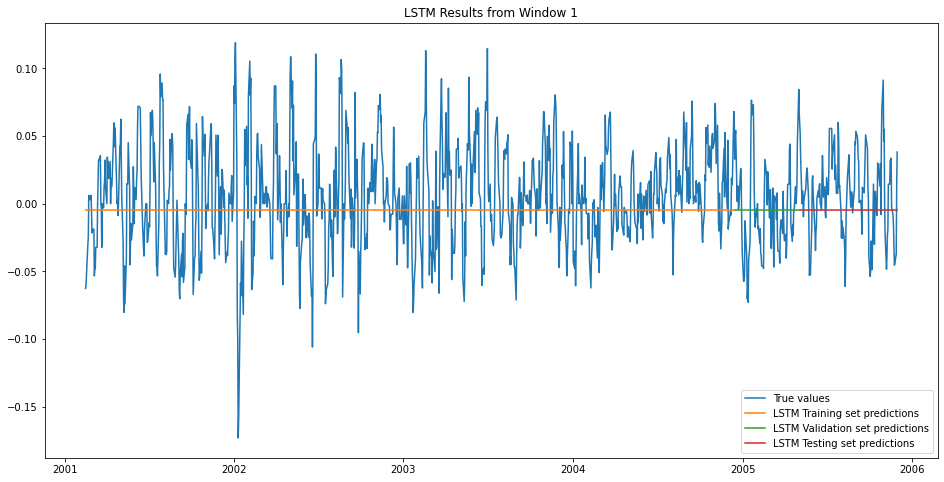

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0013497750509172603
RMSE = 0.03673928484493486
MAE = 0.02846973330028108
R-Squared = -0.014519925411852652

Results on Validation set: 
MSE = 0.0009759165855882097
RMSE = 0.031239663659972553
MAE = 0.025199613551075667
R-Squared = -0.0025209013527509594

Results on Testing set: 
MSE = 0.002236583846674284
RMSE = 0.04729253478800099
MAE = 0.03374953340239118
R-Squared = -0.13856384139232314



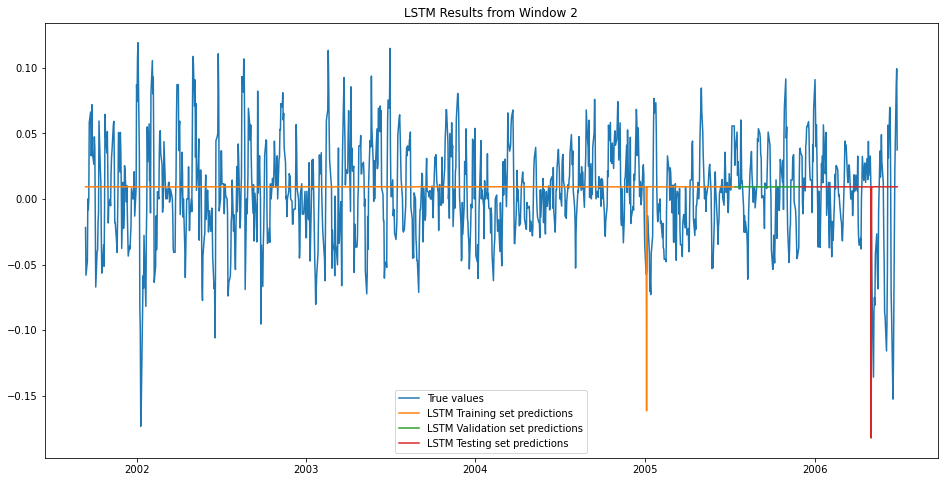

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.001141173791752518
RMSE = 0.03378126391585309
MAE = 0.026533747555011238
R-Squared = 0.016684825258972746

Results on Validation set: 
MSE = 0.002281781874875037
RMSE = 0.047768000532522156
MAE = 0.0338267193716135
R-Squared = -0.010825231338873698

Results on Testing set: 
MSE = 0.0012903285434696795
RMSE = 0.03592114340426373
MAE = 0.027218572553623997
R-Squared = -0.023368685726415706



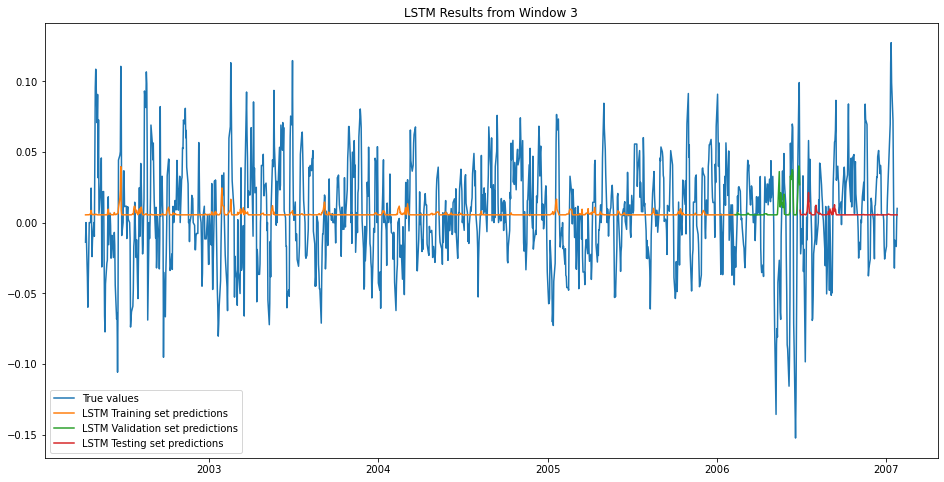

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0007232784239683059
RMSE = 0.02689383617054856
MAE = 0.02007242764796615
R-Squared = 0.39842099713732193

Results on Validation set: 
MSE = 0.0010439274687617495
RMSE = 0.03230986643057736
MAE = 0.023596539221662646
R-Squared = -0.01803514214176638

Results on Testing set: 
MSE = 0.0019538207058305366
RMSE = 0.04420204413633533
MAE = 0.034704009798668244
R-Squared = -0.2893778361240884



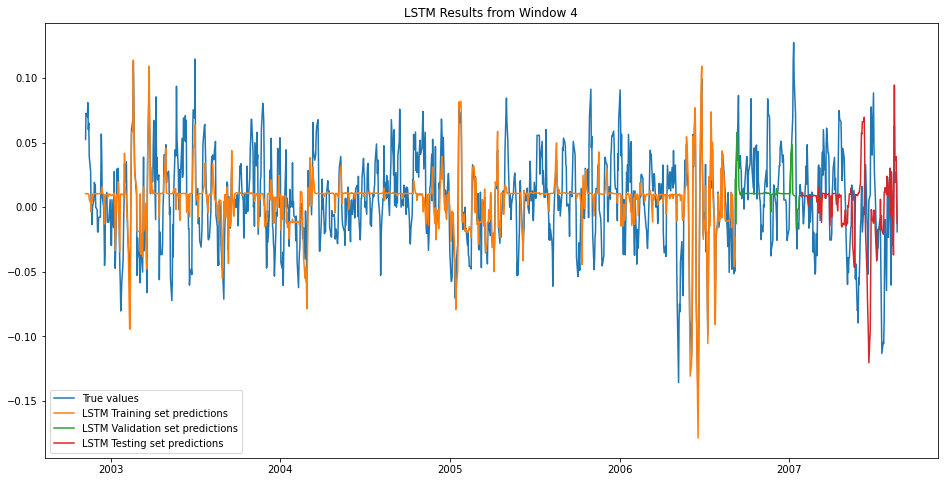

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0008058712374242837
RMSE = 0.028387871308435293
MAE = 0.021355634781221034
R-Squared = 0.2976185466902995

Results on Validation set: 
MSE = 0.0018055517281666373
RMSE = 0.04249178424315267
MAE = 0.032746007145091675
R-Squared = 0.020534212579550792

Results on Testing set: 
MSE = 0.004173600942594369
RMSE = 0.06460341277822998
MAE = 0.04758346287592675
R-Squared = -0.7766658335192171



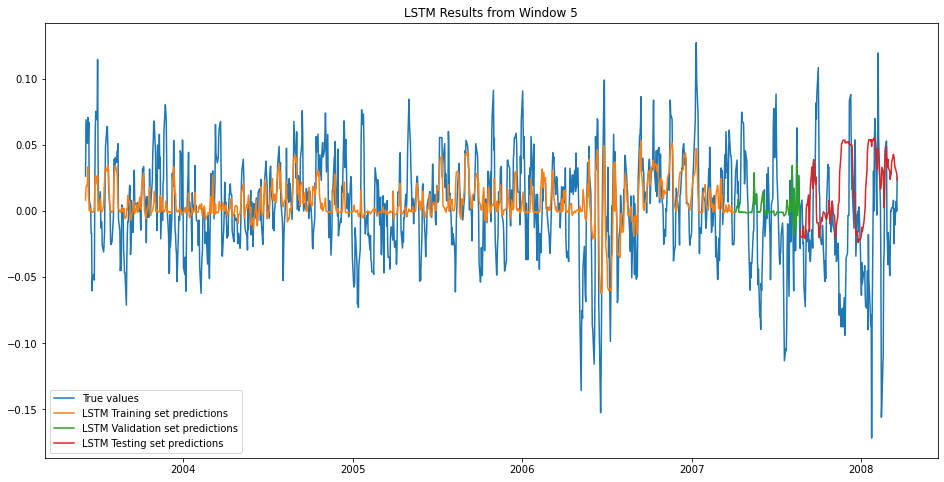

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.001787543843776653
RMSE = 0.0422793548174124
MAE = 0.03410591041793019
R-Squared = -0.4455469728299013

Results on Validation set: 
MSE = 0.0026786897075076277
RMSE = 0.05175605962114608
MAE = 0.040524725728067486
R-Squared = -0.0034044553120593513

Results on Testing set: 
MSE = 0.0021099167862577636
RMSE = 0.045933830520192453
MAE = 0.03435373796844873
R-Squared = -0.0814886004993538



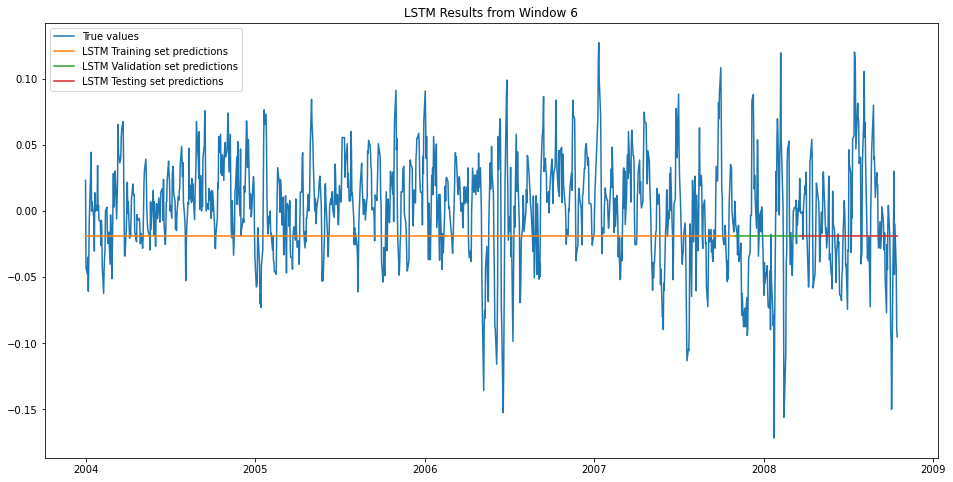

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0018506656554746546
RMSE = 0.043019363726985255
MAE = 0.03444923880298429
R-Squared = -0.21727632451939338

Results on Validation set: 
MSE = 0.0026379883549155023
RMSE = 0.051361350789436044
MAE = 0.03898708944757609
R-Squared = -0.04806873416688173

Results on Testing set: 
MSE = 0.003588744221068892
RMSE = 0.05990612840994561
MAE = 0.044357377780707016
R-Squared = -0.16358833986319388



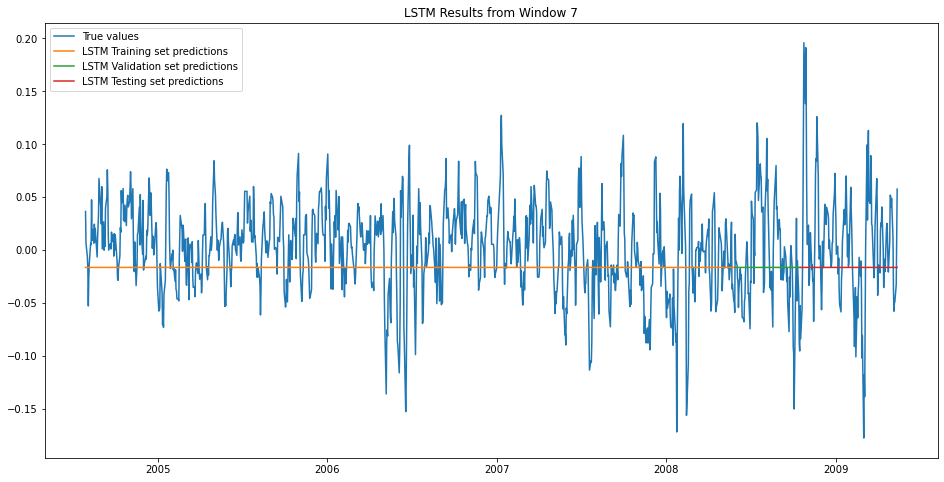

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0017469689184661501
RMSE = 0.04179675727213955
MAE = 0.031207409286457204
R-Squared = 0.03570784596113885

Results on Validation set: 
MSE = 0.002477348118854758
RMSE = 0.04977296574300911
MAE = 0.039230585781445074
R-Squared = 0.03275382297987017

Results on Testing set: 
MSE = 0.0012305874161468995
RMSE = 0.03507972941952232
MAE = 0.02830723991162093
R-Squared = -0.23411159771355972



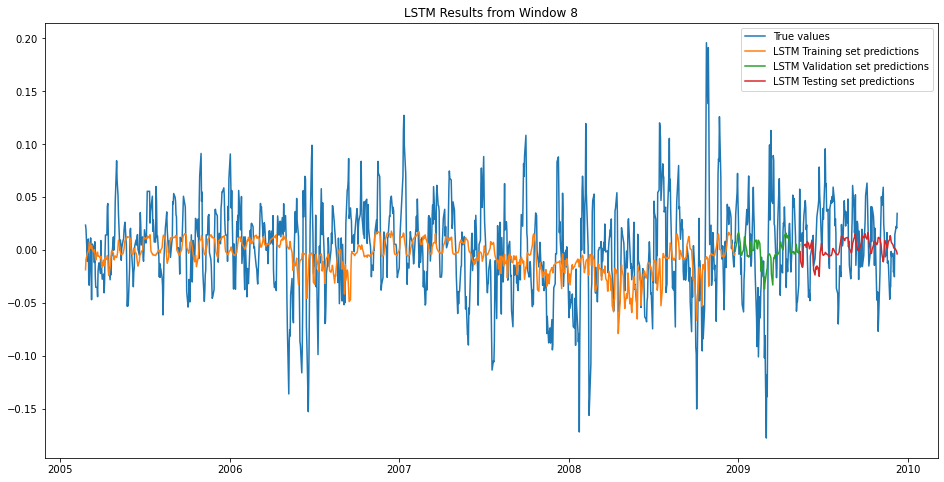

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.002145486074289493
RMSE = 0.04631939198963532
MAE = 0.035283274400491484
R-Squared = -0.06258100719763093

Results on Validation set: 
MSE = 0.0009867415650826059
RMSE = 0.03141244283850917
MAE = 0.024991843976464832
R-Squared = -0.031097431450685553

Results on Testing set: 
MSE = 0.0009112223479143137
RMSE = 0.03018645967837755
MAE = 0.024405711961398766
R-Squared = -0.001271326170771303



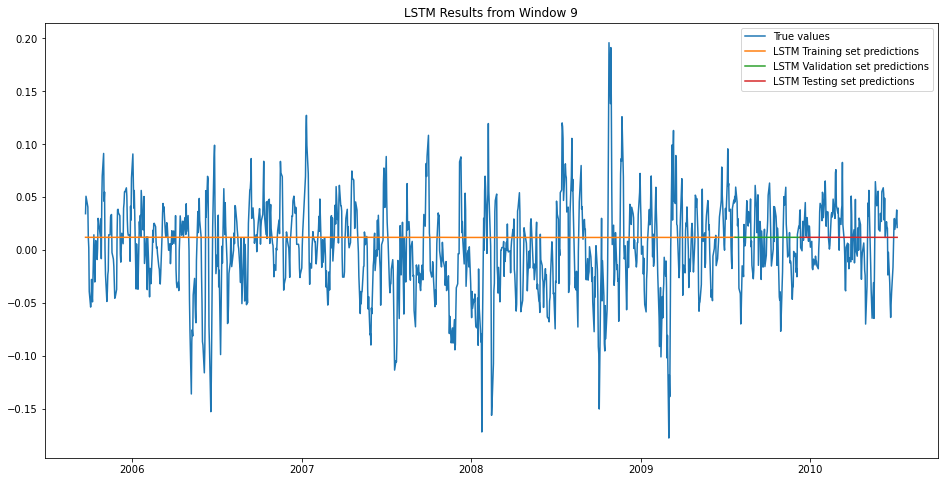

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0021533196648610966
RMSE = 0.04640387553708307
MAE = 0.03526885071625514
R-Squared = -0.07308977725397359

Results on Validation set: 
MSE = 0.001121688219967892
RMSE = 0.03349161417381808
MAE = 0.02718827183879599
R-Squared = -0.004699971555980342

Results on Testing set: 
MSE = 0.001329977084497563
RMSE = 0.036468850879861334
MAE = 0.028645734739445063
R-Squared = -0.20713820736311872



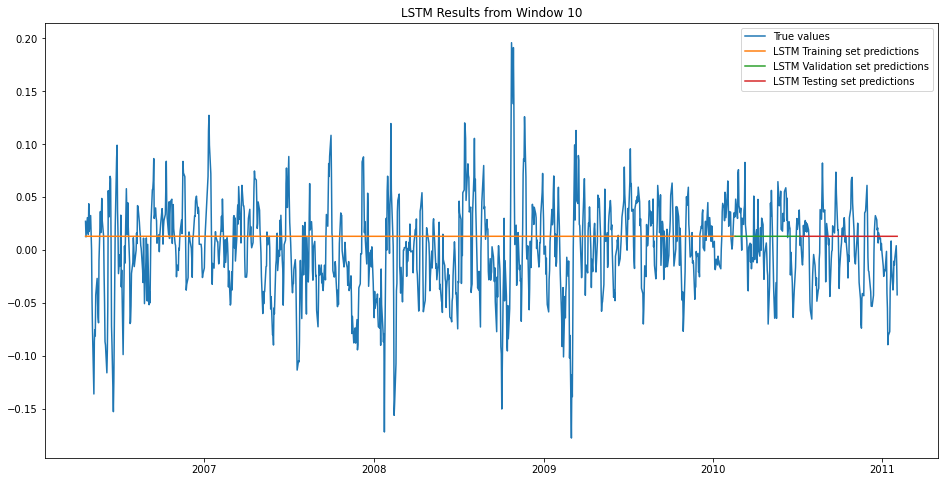

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0018233601221968416
RMSE = 0.04270082109511293
MAE = 0.032310286093653245
R-Squared = 0.014735501334292356

Results on Validation set: 
MSE = 0.0011618164494817543
RMSE = 0.034085428697344475
MAE = 0.026814556301712665
R-Squared = 0.01811486194696099

Results on Testing set: 
MSE = 0.0013937839530106725
RMSE = 0.03733341603725371
MAE = 0.027539114092620373
R-Squared = -0.11674763938767452



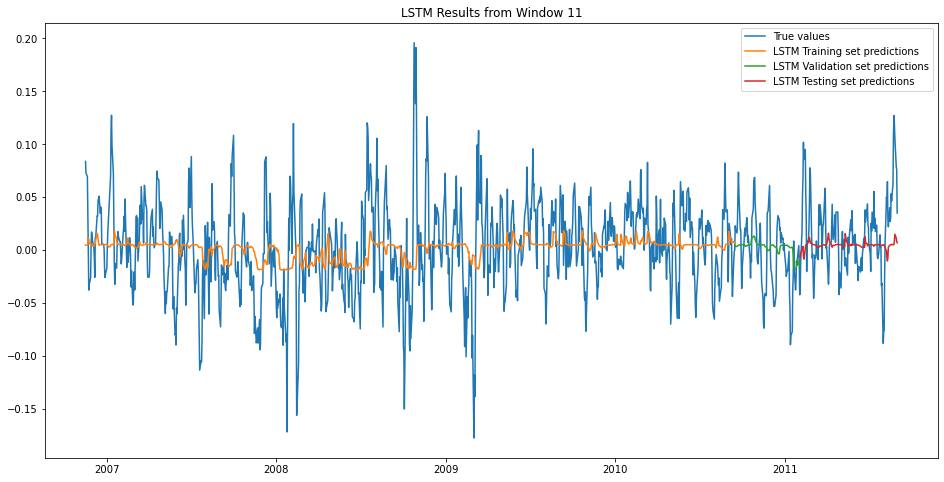

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0019909148640202892
RMSE = 0.04461966902634184
MAE = 0.03435592350113764
R-Squared = -0.08584824880899533

Results on Validation set: 
MSE = 0.001284173581854243
RMSE = 0.03583536775106742
MAE = 0.026165877689147514
R-Squared = -0.00022110002202313517

Results on Testing set: 
MSE = 0.0012593906361801786
RMSE = 0.035487894220144686
MAE = 0.027026144908216376
R-Squared = -0.01846087121963258



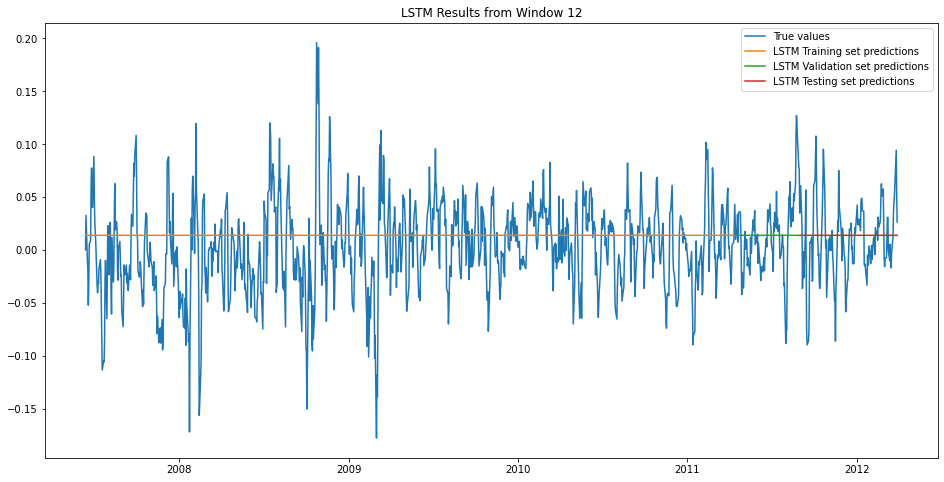

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0018734678602024982
RMSE = 0.04328357494711473
MAE = 0.03265067282185259
R-Squared = -0.06725490642376819

Results on Validation set: 
MSE = 0.0008707726977058147
RMSE = 0.02950885795326235
MAE = 0.023023183921960424
R-Squared = -0.010016557797076109

Results on Testing set: 
MSE = 0.000994280319206025
RMSE = 0.0315322108201443
MAE = 0.02432486062900987
R-Squared = -0.018498622708205126



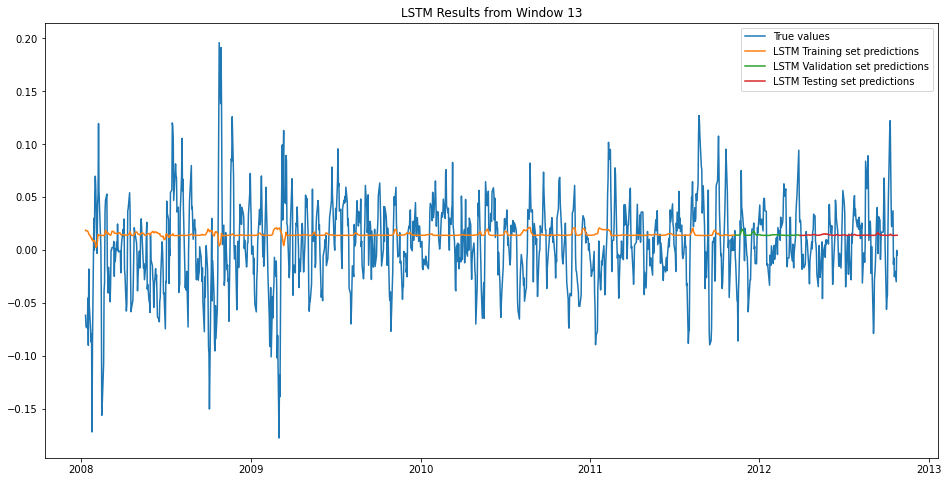

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0014985173942182444
RMSE = 0.038710688371795254
MAE = 0.029088784453083622
R-Squared = -0.021947563014211635

Results on Validation set: 
MSE = 0.001235779665344698
RMSE = 0.035153657922678515
MAE = 0.02719849541180459
R-Squared = 0.00040175941692144335

Results on Testing set: 
MSE = 0.001362123991836348
RMSE = 0.03690696400188382
MAE = 0.02677555371244201
R-Squared = -0.04038061826106998



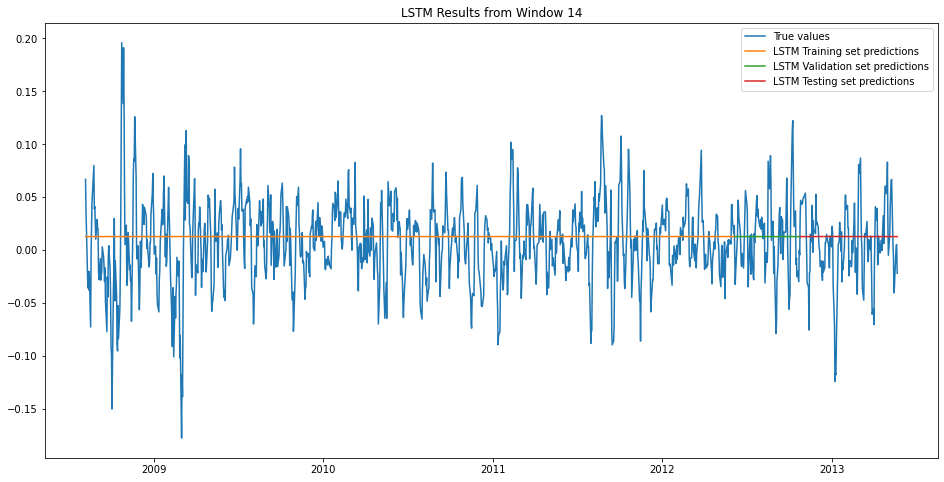

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0010056137817435569
RMSE = 0.03171141406092697
MAE = 0.024221559091505442
R-Squared = 0.10529237377828538

Results on Validation set: 
MSE = 0.0015825092128988628
RMSE = 0.039780764357901205
MAE = 0.02806891336153058
R-Squared = 0.0028598937538794056

Results on Testing set: 
MSE = 0.002486330203158795
RMSE = 0.04986311465561287
MAE = 0.03719971045056519
R-Squared = -0.03168843067495719



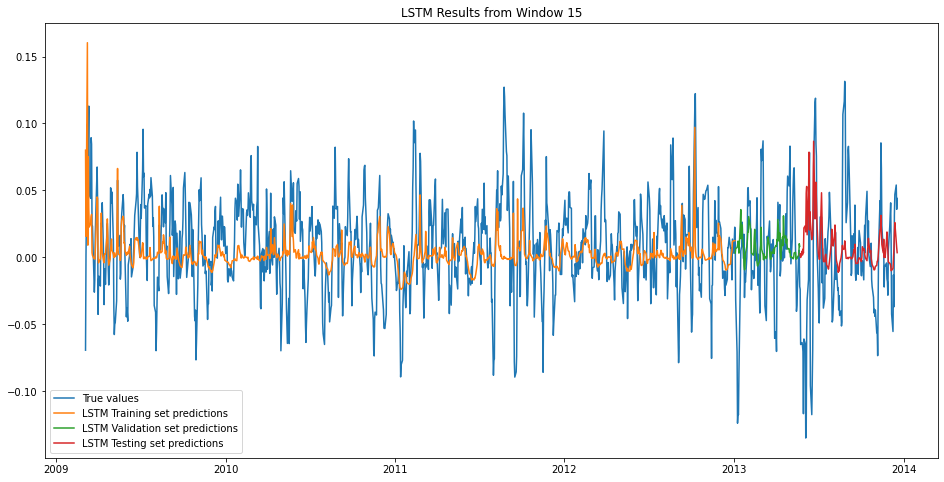

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0011543338280374429
RMSE = 0.03397548863574213
MAE = 0.02533760339924248
R-Squared = 0.11241703400820124

Results on Validation set: 
MSE = 0.0014677975954990893
RMSE = 0.03831184667304735
MAE = 0.029258583097894766
R-Squared = 0.1277085162286551

Results on Testing set: 
MSE = 0.002020304105242948
RMSE = 0.044947793107592594
MAE = 0.03145967935960889
R-Squared = -0.44943294738852413



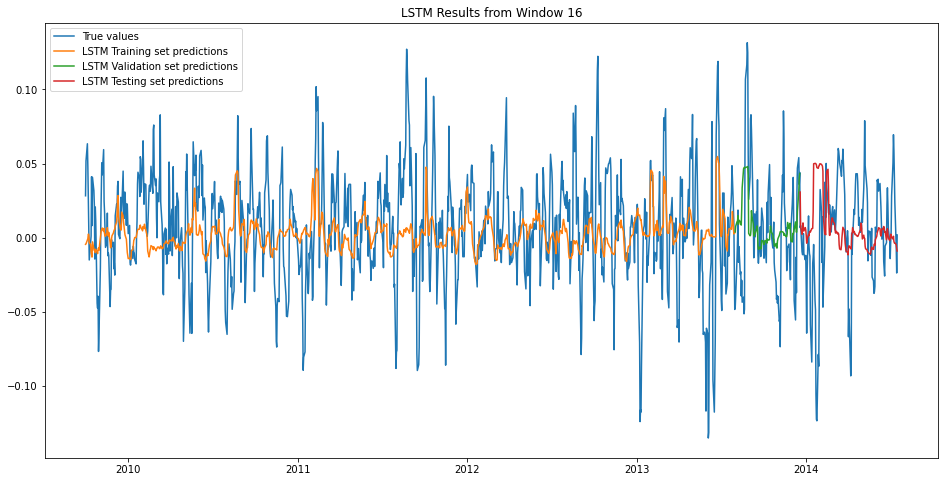

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0013930525289772321
RMSE = 0.037323618915871916
MAE = 0.027735306098380545
R-Squared = 0.042170238287181805

Results on Validation set: 
MSE = 0.0007882841908865296
RMSE = 0.02807639917949824
MAE = 0.021836070054098985
R-Squared = 0.20280797443659815

Results on Testing set: 
MSE = 0.0015770134632593774
RMSE = 0.03971162881649879
MAE = 0.030722671215656173
R-Squared = 0.013885582845380662



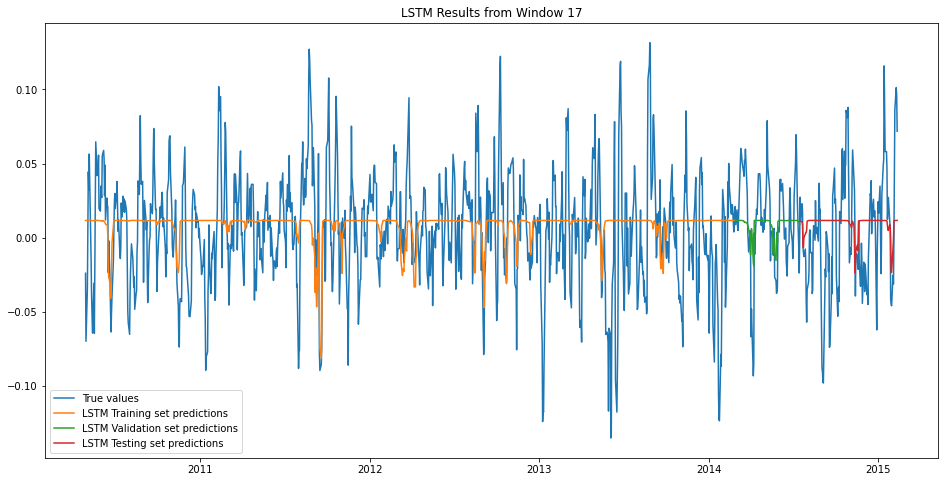

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0015385726959680915
RMSE = 0.039224643987780076
MAE = 0.02894522541782099
R-Squared = -0.0524310161092294

Results on Validation set: 
MSE = 0.001475081462008328
RMSE = 0.03840678926971543
MAE = 0.030691118288505487
R-Squared = 0.025498789104480335

Results on Testing set: 
MSE = 0.0008300883312774738
RMSE = 0.028811253552691415
MAE = 0.02336344619317415
R-Squared = 0.21046027850108195



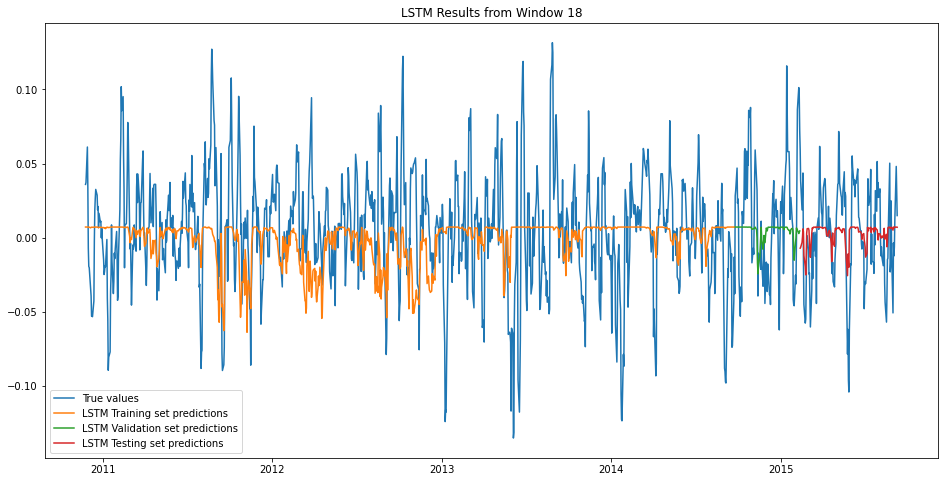

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0009536919206136368
RMSE = 0.030881902801052217
MAE = 0.021270691657244156
R-Squared = 0.3680262380605901

Results on Validation set: 
MSE = 0.0006893723492889856
RMSE = 0.026255901227895142
MAE = 0.01972160267468815
R-Squared = 0.39953314416218455

Results on Testing set: 
MSE = 0.0020539512575466173
RMSE = 0.045320539025331744
MAE = 0.03450124045617405
R-Squared = -0.184633804955751



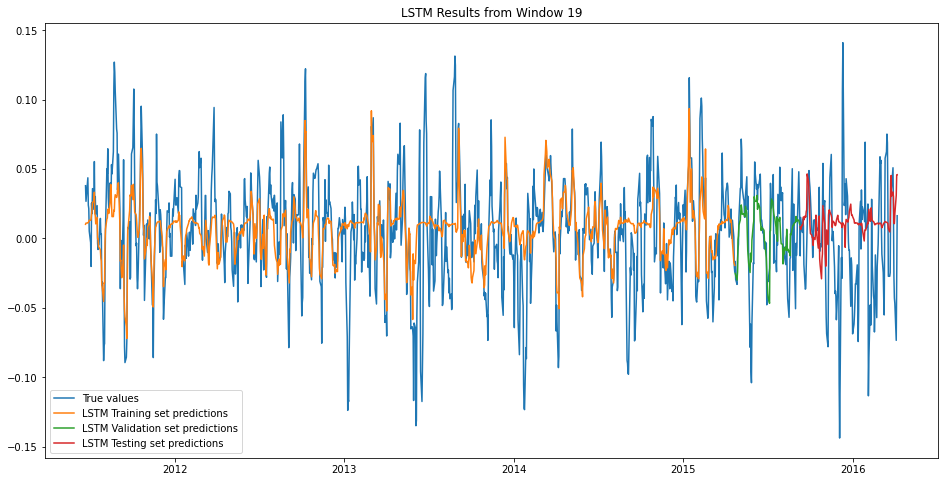

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0011790318416769379
RMSE = 0.034337033093686735
MAE = 0.024718245410533426
R-Squared = 0.15829318383403534

Results on Validation set: 
MSE = 0.00223758699013071
RMSE = 0.0473031393263778
MAE = 0.03750391049511352
R-Squared = -0.05706827358923805

Results on Testing set: 
MSE = 0.0014698498426013503
RMSE = 0.03833862077072349
MAE = 0.03172436302847314
R-Squared = -0.15865952437275688



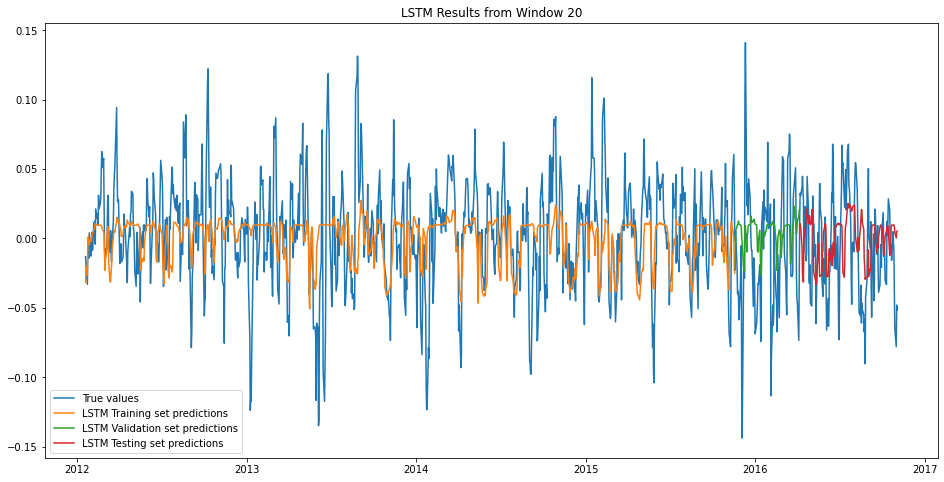

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0016217249830405291
RMSE = 0.040270646667771914
MAE = 0.031129688892852145
R-Squared = -0.019954689948354254

Results on Validation set: 
MSE = 0.0014084241743176718
RMSE = 0.03752897779473446
MAE = 0.030610396417931892
R-Squared = 0.000723065771215059

Results on Testing set: 
MSE = 0.0012307652091933386
RMSE = 0.03508226345595932
MAE = 0.027671922211057562
R-Squared = 0.001265182043237556



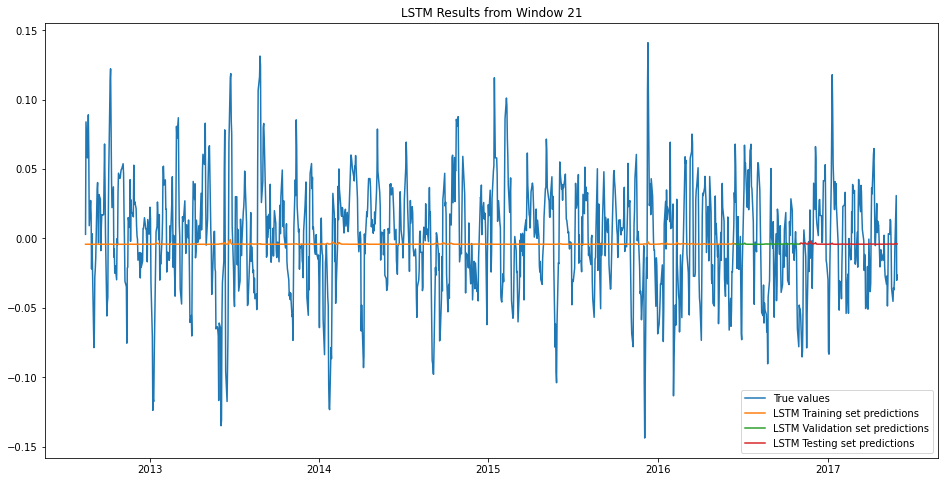

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0016601964663493587
RMSE = 0.04074550854203882
MAE = 0.032023641512297564
R-Squared = -0.047809026658911735

Results on Validation set: 
MSE = 0.0008132346138983933
RMSE = 0.028517268696324923
MAE = 0.023289246371697655
R-Squared = 0.09177284043224188

Results on Testing set: 
MSE = 0.0014984416589368167
RMSE = 0.038709710137597476
MAE = 0.029822476615529527
R-Squared = -0.09209849697840822



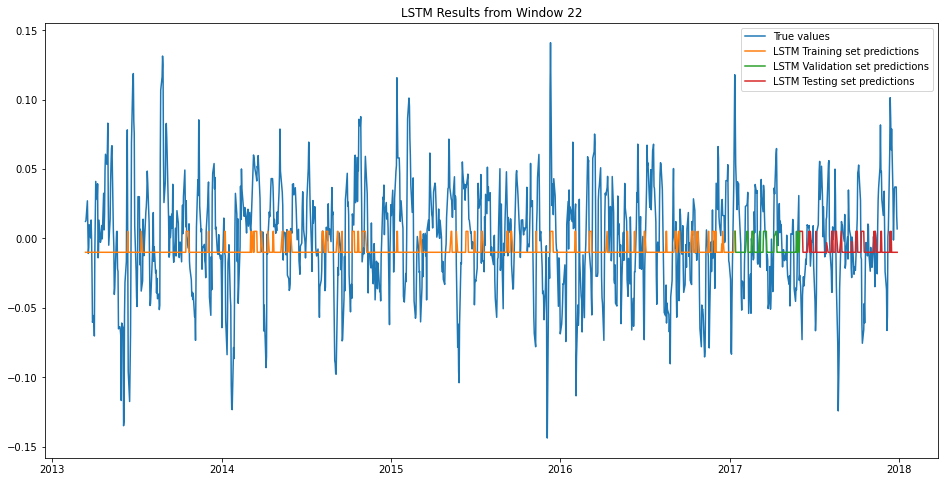

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0011255885733595613
RMSE = 0.033549792448829864
MAE = 0.02521345412265437
R-Squared = 0.17741563838856445

Results on Validation set: 
MSE = 0.0014867463155862845
RMSE = 0.038558349492506604
MAE = 0.028899660080352538
R-Squared = 0.036603033171774046

Results on Testing set: 
MSE = 0.001243680684372661
RMSE = 0.03526585720456347
MAE = 0.02908298951546593
R-Squared = -0.087749006757049



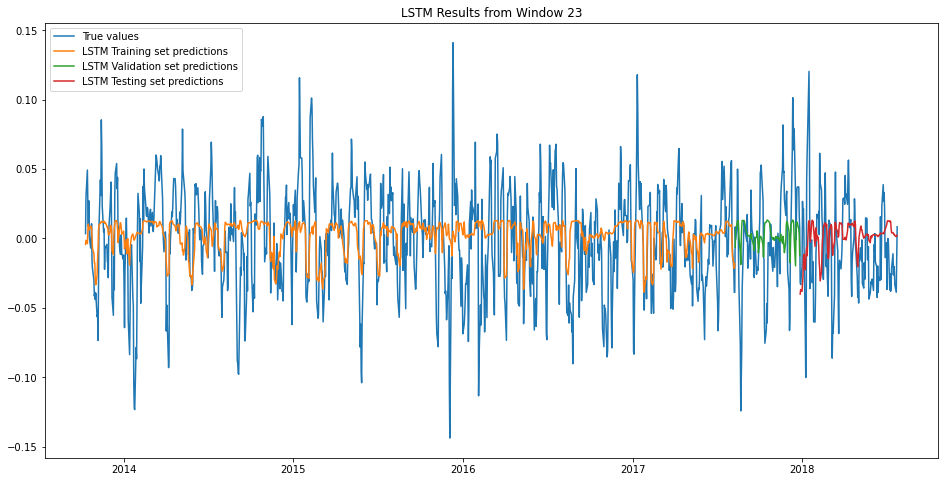

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0012202918409899976
RMSE = 0.03493267583495426
MAE = 0.02665200929733026
R-Squared = 0.11870704324656123

Results on Validation set: 
MSE = 0.0007027834113851937
RMSE = 0.026510062455324276
MAE = 0.021372615862212917
R-Squared = 0.033044263814574704

Results on Testing set: 
MSE = 0.001813460415441437
RMSE = 0.04258474392832998
MAE = 0.03214979213253475
R-Squared = -0.2879062006873341



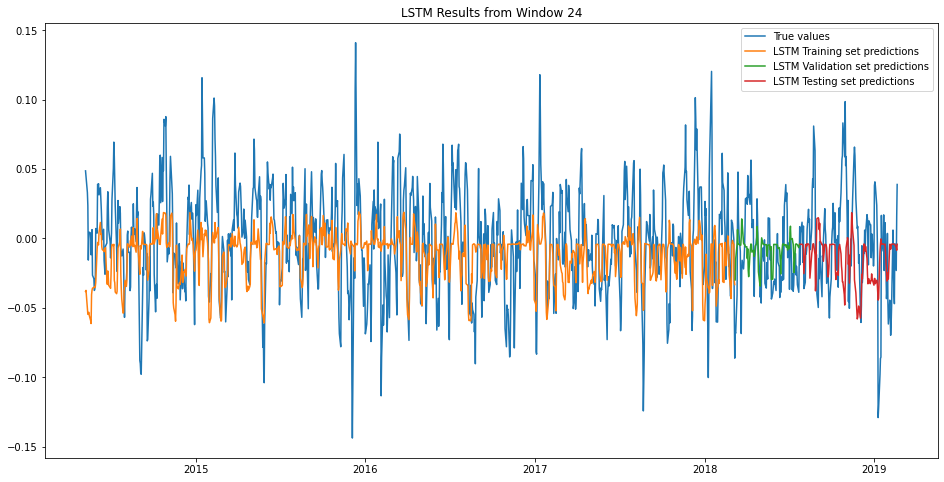

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4918

Results on Training set: 
MSE = 0.0013117430988623577
RMSE = 0.036217994130851
MAE = 0.028529508780959383
R-Squared = 0.006761481235239675

Results on Validation set: 
MSE = 0.0017227824050727316
RMSE = 0.0415064140232896
MAE = 0.03099926178824402
R-Squared = 0.0007464879288342496

Results on Testing set: 
MSE = 0.0015935785104776042
RMSE = 0.039919650680806364
MAE = 0.029877594512101764
R-Squared = -0.007188808578776573



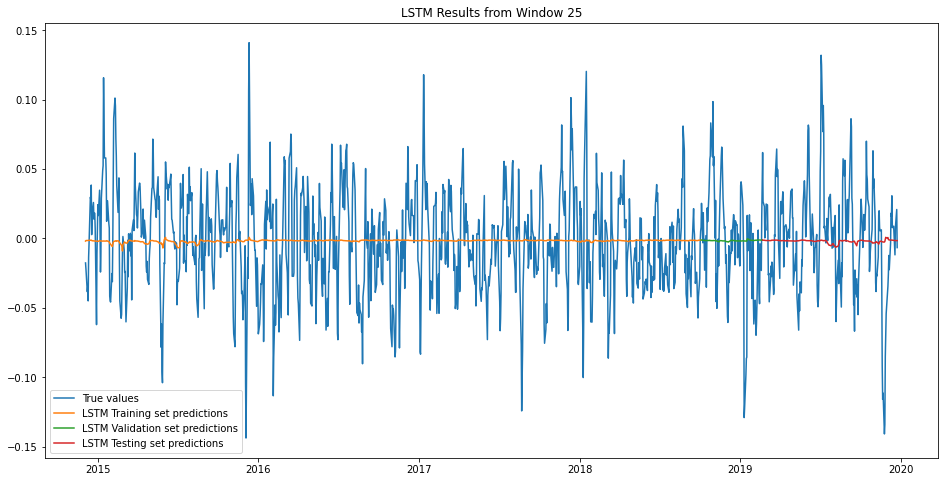

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 200
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.0019620658397930023
  dropout =  0.0796603052293783
  units = 247

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 82
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0014581966311958592
RMSE = 0.03818634089823034
MAE = 0.029350612760039606
R-Squared = 0.047312319253715485

Results on Validation set: 
MSE = 0.0013612704672513497
RMSE = 0.0368953989984029
MAE = 0.0300517855878962
R-Squared = -0.10966561805665886

Results on Testing set: 
MSE = 0.0008879131975137629
RMSE = 0.02979787236555259
MAE = 0.023672609728609708
R-Squared = -0.11439398284601054



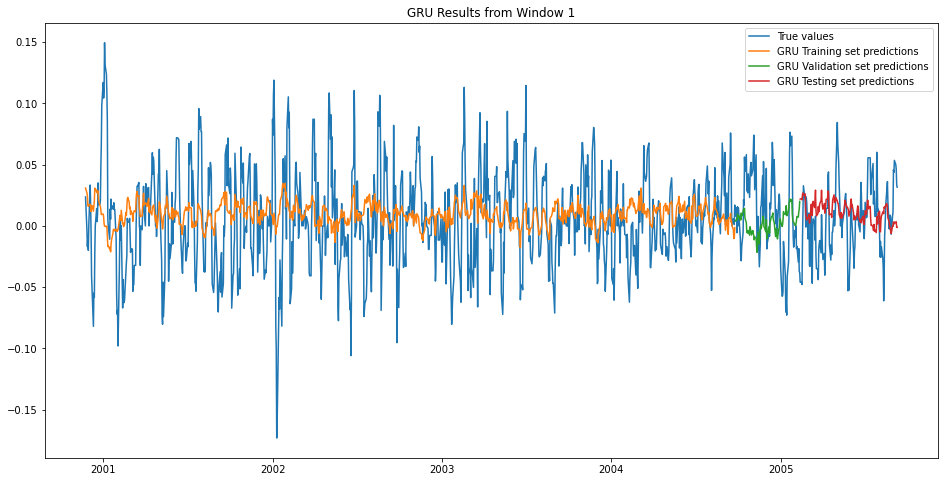

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0012159368248043979
RMSE = 0.03487028570006844
MAE = 0.02674023856074633
R-Squared = 0.12948292522502902

Results on Validation set: 
MSE = 0.0006091043417388325
RMSE = 0.024680039338275627
MAE = 0.019035830246784156
R-Squared = 0.21057619586411136

Results on Testing set: 
MSE = 0.0009307120776603543
RMSE = 0.030507574103169104
MAE = 0.025396384284383452
R-Squared = -0.0507125405327542



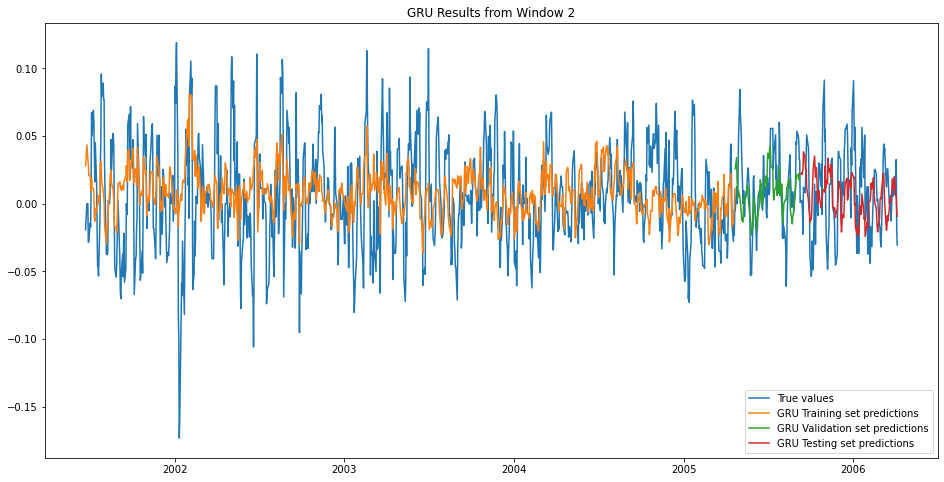

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0010191910844567172
RMSE = 0.03192477226945742
MAE = 0.02492146460254444
R-Squared = 0.14558675543185817

Results on Validation set: 
MSE = 0.000747348227072397
RMSE = 0.027337670476329855
MAE = 0.0214625638272197
R-Squared = 0.06062197275478809

Results on Testing set: 
MSE = 0.0028645464064918666
RMSE = 0.05352145743990784
MAE = 0.04039695911217855
R-Squared = -0.3267364528651835



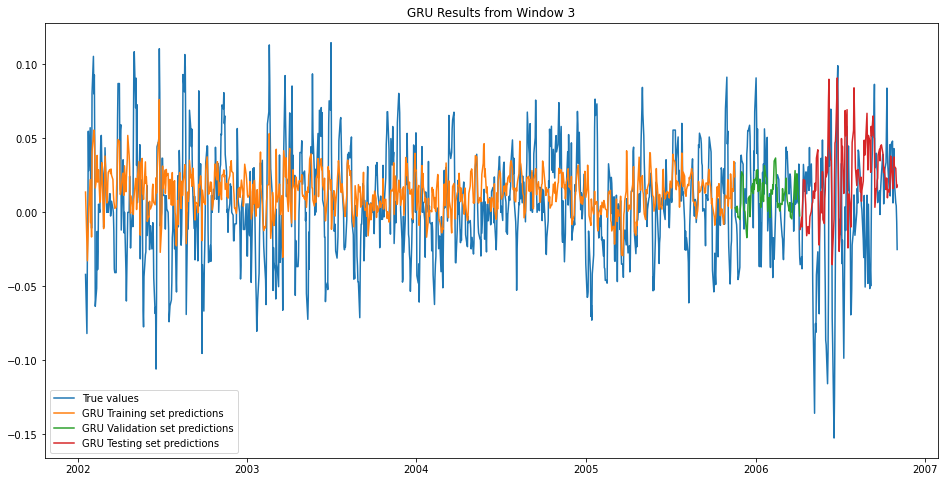

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.001095255119502407
RMSE = 0.03309463883323713
MAE = 0.02521836754719136
R-Squared = 0.058045739951334885

Results on Validation set: 
MSE = 0.0014516967085784237
RMSE = 0.03810113789086126
MAE = 0.029773983062872454
R-Squared = 0.2007636426165793

Results on Testing set: 
MSE = 0.0016864573210391468
RMSE = 0.041066498767719985
MAE = 0.03243196680160018
R-Squared = -0.27507911299967125



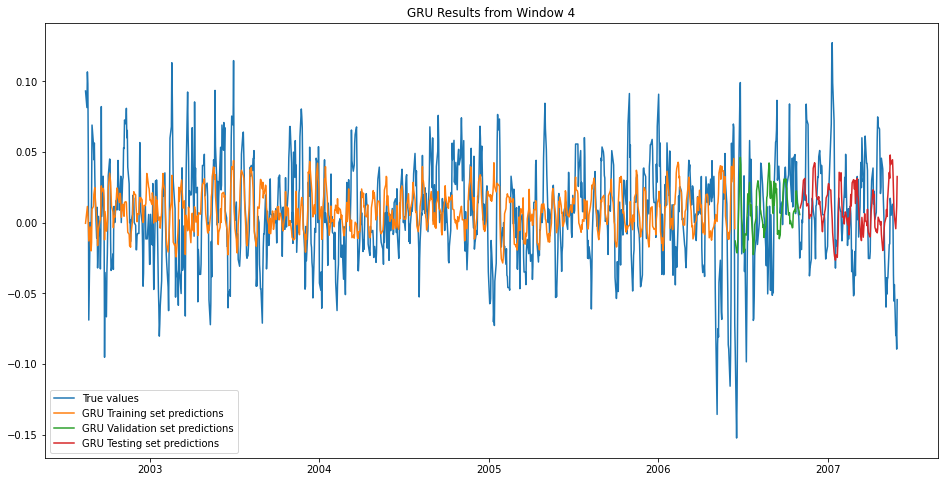

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0010351412259197402
RMSE = 0.03217361070690917
MAE = 0.02444269036353855
R-Squared = 0.12376336011147726

Results on Validation set: 
MSE = 0.0013425164795358299
RMSE = 0.03664036680405683
MAE = 0.029560967583563972
R-Squared = -0.04755272125804422

Results on Testing set: 
MSE = 0.002820879143916575
RMSE = 0.053111949163221026
MAE = 0.04163698689352701
R-Squared = -0.5300223211398698



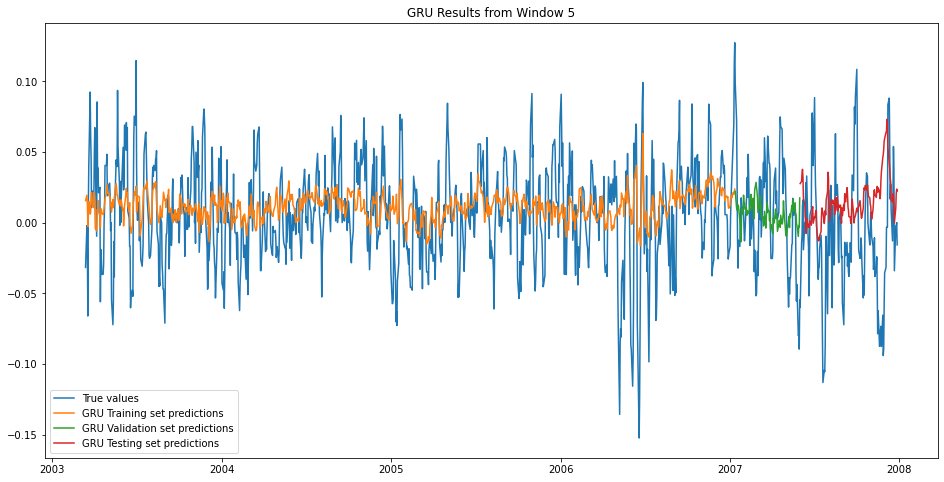

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0012754659305232046
RMSE = 0.03571366587908898
MAE = 0.027774322905553046
R-Squared = -0.04596975378474322

Results on Validation set: 
MSE = 0.0022237214166577787
RMSE = 0.0471563507563698
MAE = 0.036170756250079525
R-Squared = -0.25985926933863923

Results on Testing set: 
MSE = 0.0030320402537361312
RMSE = 0.05506396511091561
MAE = 0.04428019900380049
R-Squared = -0.2989133850861363



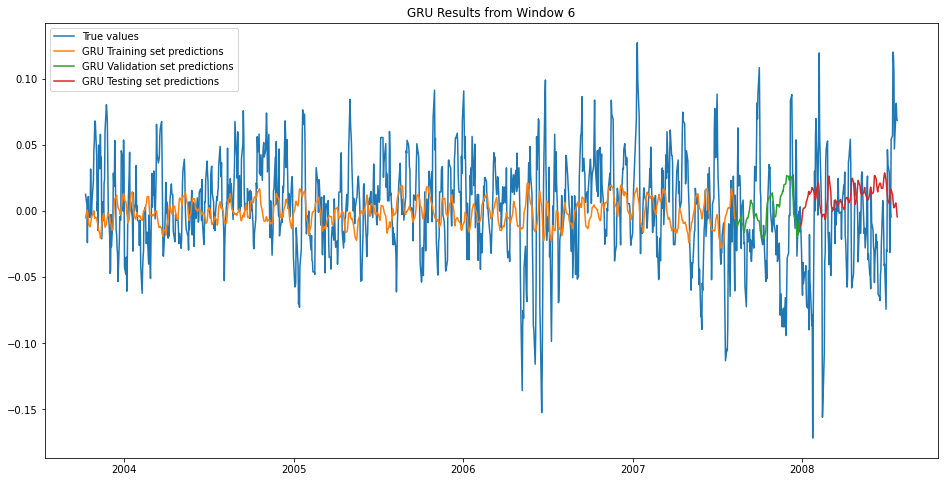

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.001048167028417215
RMSE = 0.03237540777221524
MAE = 0.02520547679127243
R-Squared = 0.29834136522687305

Results on Validation set: 
MSE = 0.0013527024585041603
RMSE = 0.03677910355764752
MAE = 0.028236760612113845
R-Squared = 0.13853845862613068

Results on Testing set: 
MSE = 0.00344444761912191
RMSE = 0.05868941658529168
MAE = 0.04808521779284949
R-Squared = -0.2093280271325899



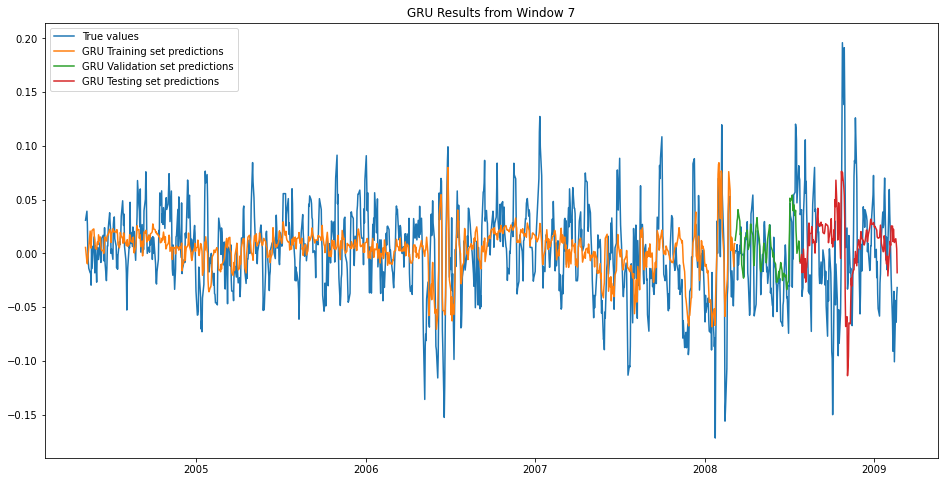

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0006142685470521056
RMSE = 0.02478444163284914
MAE = 0.01831276250275365
R-Squared = 0.6248031368055993

Results on Validation set: 
MSE = 0.002966921180045417
RMSE = 0.05446945180599321
MAE = 0.04112060457428371
R-Squared = 0.10214958224771131

Results on Testing set: 
MSE = 0.0027468069773414093
RMSE = 0.05240998928965173
MAE = 0.03779535619114852
R-Squared = -0.45814246169198825



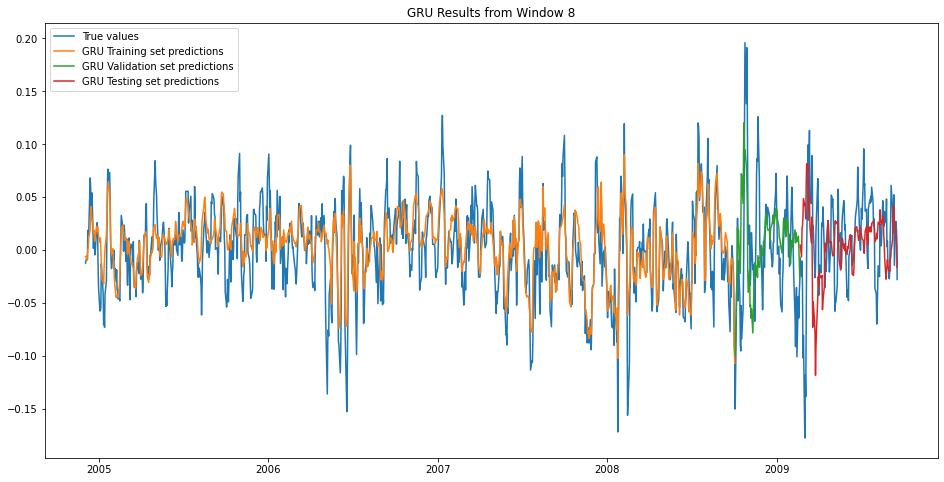

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0017179363414599965
RMSE = 0.04144799562656796
MAE = 0.03073063174889485
R-Squared = 0.13706488018960494

Results on Validation set: 
MSE = 0.0011917927696759984
RMSE = 0.03452235174022764
MAE = 0.027948413623706814
R-Squared = -0.05267177677669155

Results on Testing set: 
MSE = 0.0008665037259227034
RMSE = 0.02943643534673829
MAE = 0.024170764795848055
R-Squared = -0.1357515767802484



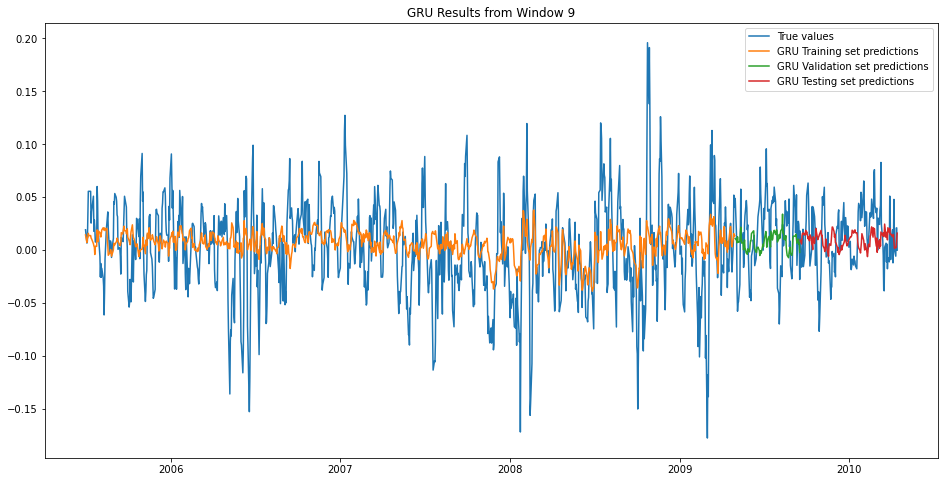

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0017299765179197974
RMSE = 0.041592986402995843
MAE = 0.031195626966694243
R-Squared = 0.13281503880869183

Results on Validation set: 
MSE = 0.0006485097693893138
RMSE = 0.025465854970711542
MAE = 0.02018987192899048
R-Squared = -0.07408905584535708

Results on Testing set: 
MSE = 0.001328800587634416
RMSE = 0.03645271715022648
MAE = 0.029239376956919437
R-Squared = -0.26176355540164153



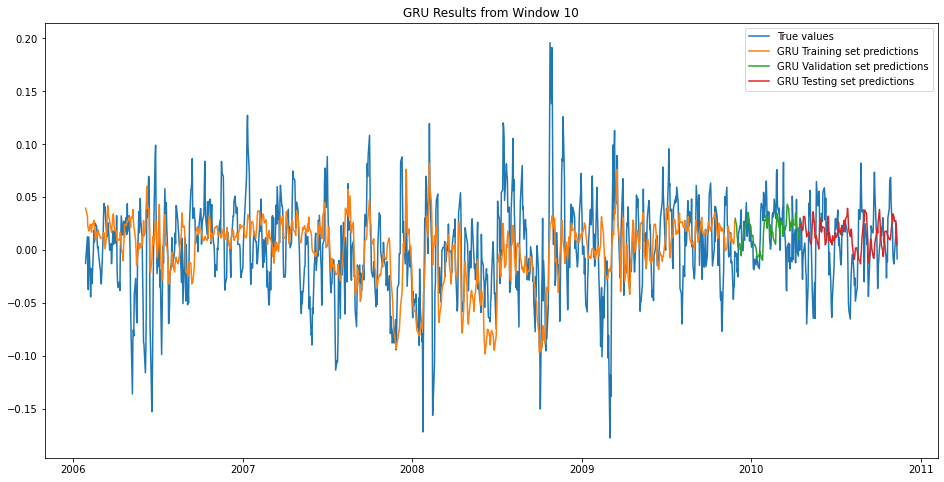

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0019727142199721798
RMSE = 0.04441524760678679
MAE = 0.0340003140365105
R-Squared = -0.0582385392511644

Results on Validation set: 
MSE = 0.0008091386549508098
RMSE = 0.028445362626460042
MAE = 0.02262574063707763
R-Squared = 0.06656180241613074

Results on Testing set: 
MSE = 0.0012070422456388708
RMSE = 0.03474251351930183
MAE = 0.02722935778266662
R-Squared = -0.04358652315643741



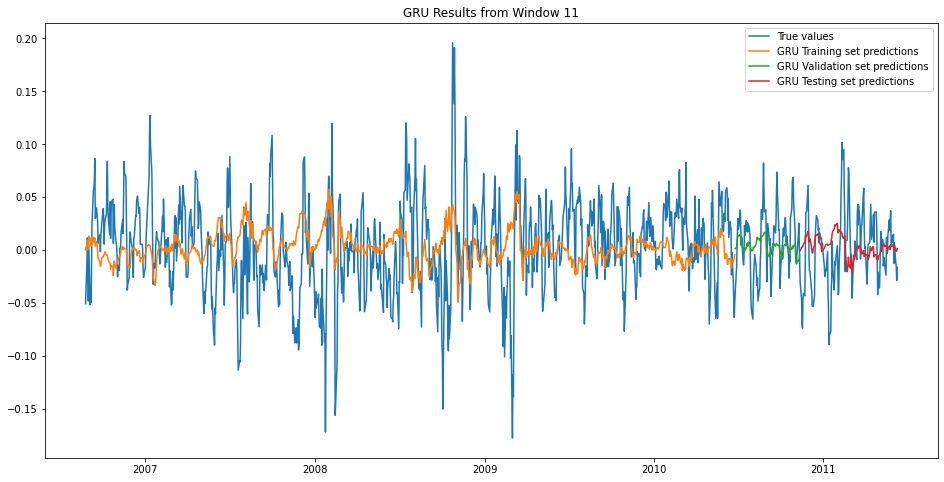

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001501305796920421
RMSE = 0.0387466875606215
MAE = 0.02943930469994185
R-Squared = 0.1853412590134309

Results on Validation set: 
MSE = 0.0009307345624937415
RMSE = 0.03050794261325633
MAE = 0.023199054286325054
R-Squared = -0.037318084577475874

Results on Testing set: 
MSE = 0.002047800349061335
RMSE = 0.045252628090104725
MAE = 0.0345733666595462
R-Squared = -0.21095762433816123



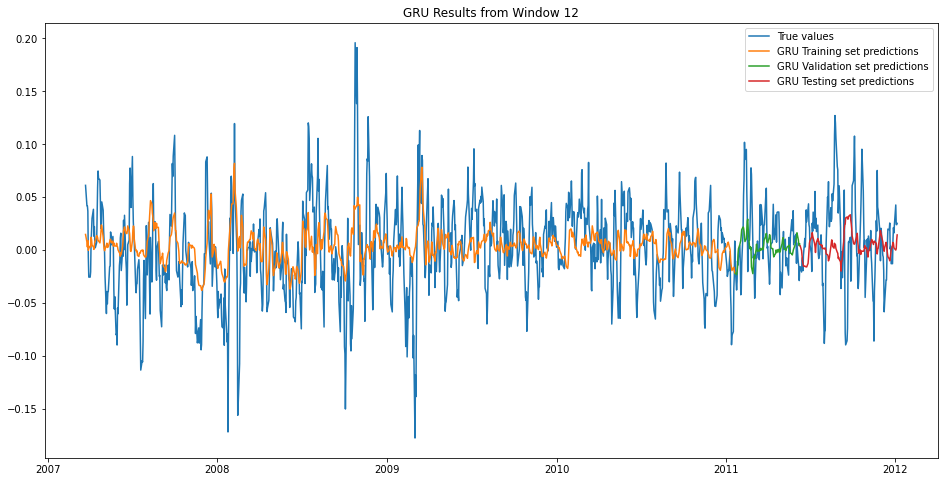

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0015241343684968551
RMSE = 0.03904016353061108
MAE = 0.02916320307375051
R-Squared = 0.11522696079798289

Results on Validation set: 
MSE = 0.001963402188353603
RMSE = 0.04431029438351322
MAE = 0.033252565117913135
R-Squared = 0.024335586781099705

Results on Testing set: 
MSE = 0.0005968046063465554
RMSE = 0.024429584653582536
MAE = 0.019830624809570107
R-Squared = 0.0060323738967582585



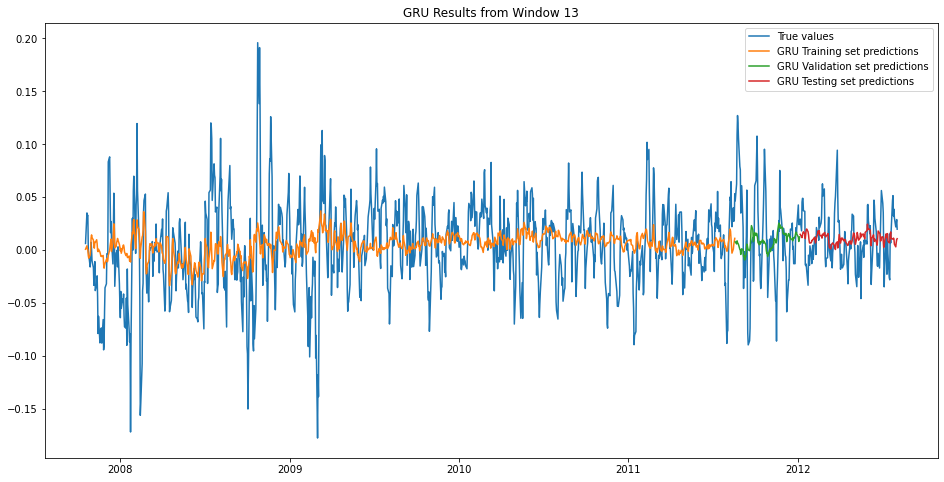

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0013889534407809023
RMSE = 0.03726866566944546
MAE = 0.028127112519962253
R-Squared = 0.122846291395461

Results on Validation set: 
MSE = 0.0006462954526806764
RMSE = 0.02542234160498746
MAE = 0.019638133032613973
R-Squared = -0.02904850835064865

Results on Testing set: 
MSE = 0.0014962047710400063
RMSE = 0.03868080623565137
MAE = 0.028231192479749177
R-Squared = 0.008022996024145135



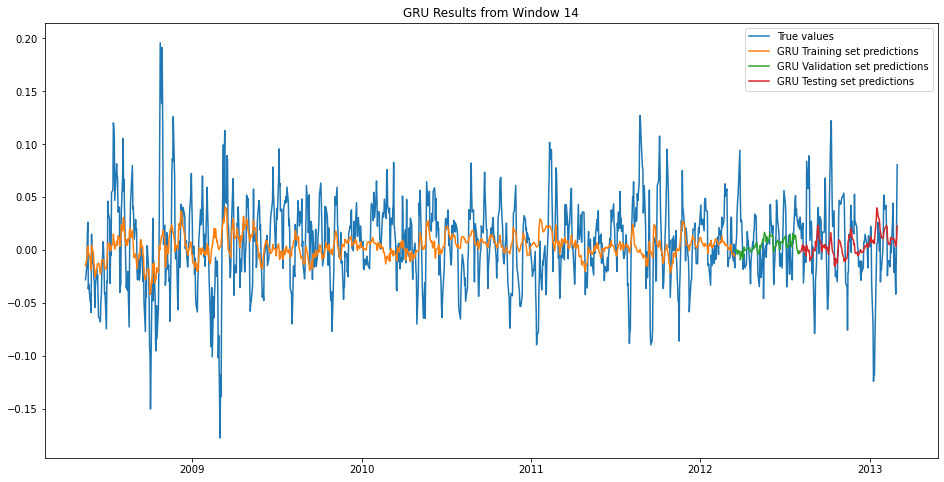

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0012174588035842161
RMSE = 0.03489210230960892
MAE = 0.026279793312324853
R-Squared = 0.03562238604139245

Results on Validation set: 
MSE = 0.0013366874755377453
RMSE = 0.03656073680244622
MAE = 0.02582766753211343
R-Squared = -0.046341695121958626

Results on Testing set: 
MSE = 0.0025446815799899337
RMSE = 0.05044483700033071
MAE = 0.037597368771451686
R-Squared = -0.023059152287931095



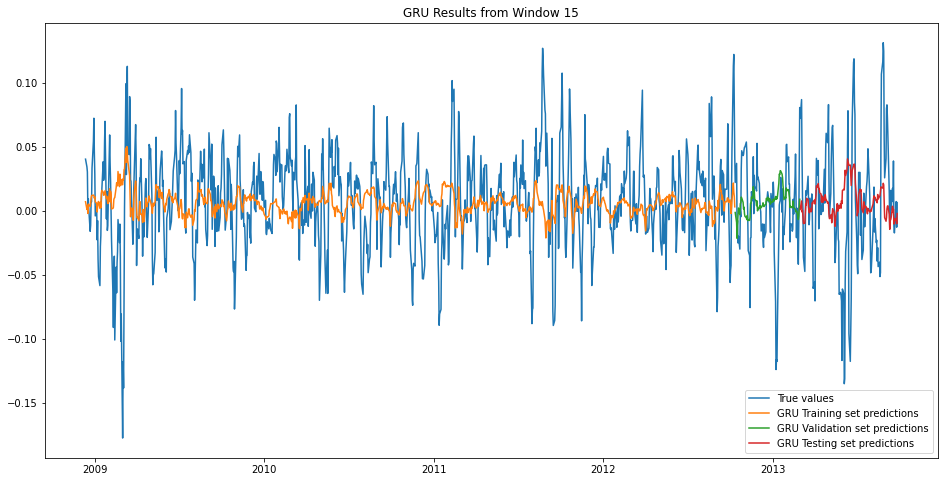

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0010739703914304276
RMSE = 0.032771487476622535
MAE = 0.02475261667313217
R-Squared = 0.05768371995343702

Results on Validation set: 
MSE = 0.0029695890111214054
RMSE = 0.054493935544438384
MAE = 0.041815773966747856
R-Squared = 0.0279713202733326

Results on Testing set: 
MSE = 0.0017533070097020354
RMSE = 0.04187250899697838
MAE = 0.03057951151960424
R-Squared = -0.16603204905612912



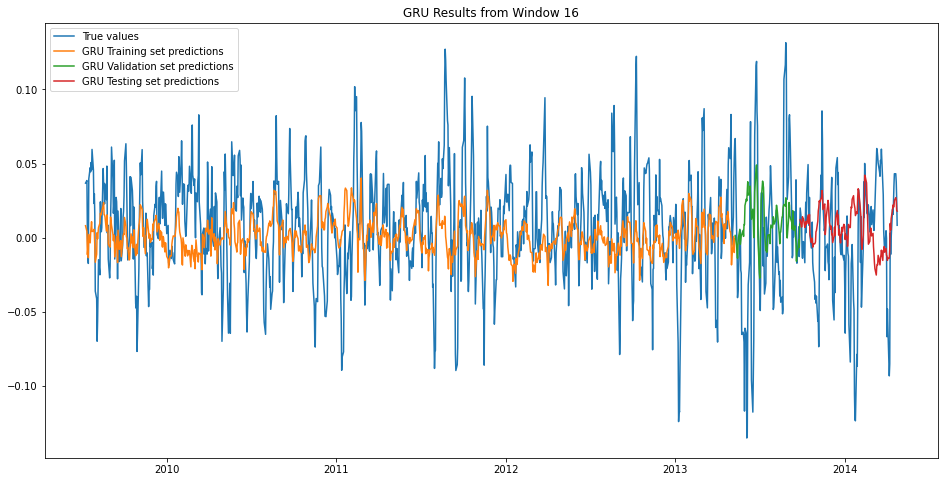

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0013078196392386193
RMSE = 0.036163789060863344
MAE = 0.027249841261519605
R-Squared = 0.05028277972129891

Results on Validation set: 
MSE = 0.0018801111652785882
RMSE = 0.04336024867639239
MAE = 0.03183034396371446
R-Squared = -0.062075131777542314

Results on Testing set: 
MSE = 0.001228349440423994
RMSE = 0.03504781648582397
MAE = 0.026323644759659946
R-Squared = 0.007031355855964705



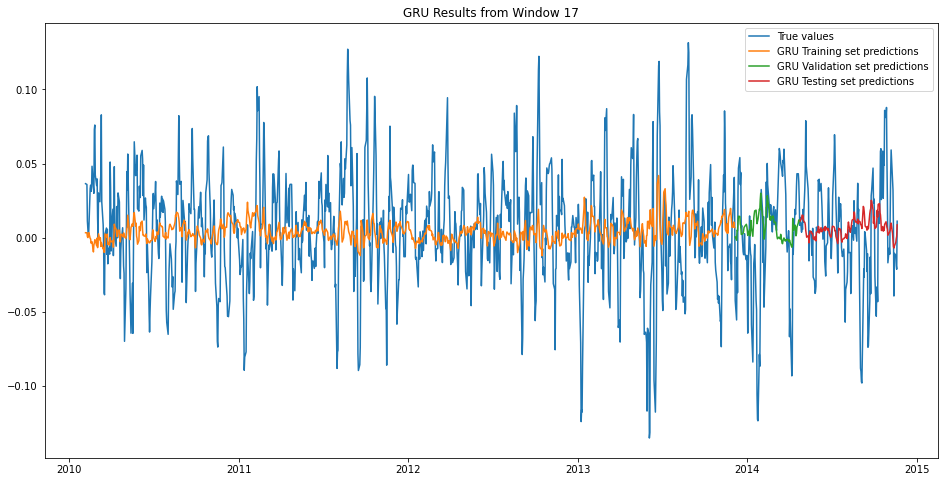

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0011093767729564046
RMSE = 0.033307308101322215
MAE = 0.024280705462713024
R-Squared = 0.22327713261288795

Results on Validation set: 
MSE = 0.001263467411049419
RMSE = 0.03554528676279626
MAE = 0.02664143236443446
R-Squared = 0.17606886780593556

Results on Testing set: 
MSE = 0.0015720094320436269
RMSE = 0.03964857414893538
MAE = 0.03017668293317281
R-Squared = -0.10534907637418955



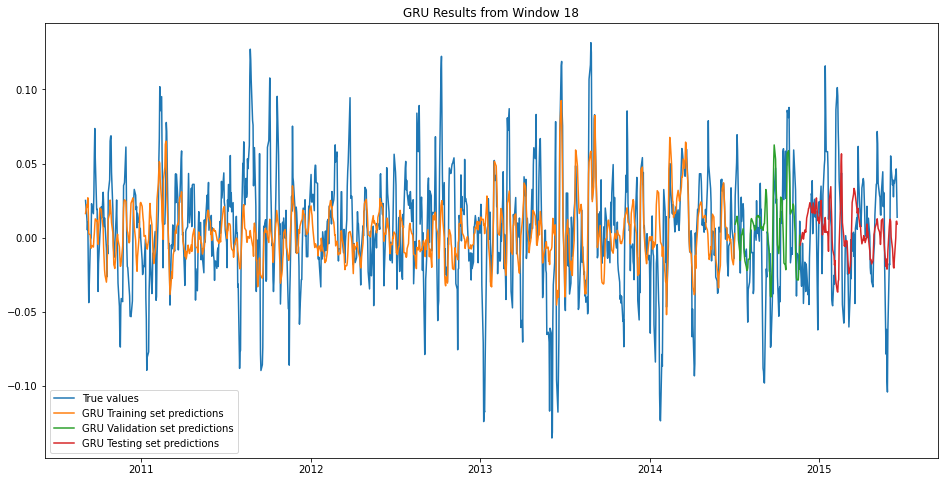

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.00137698471512038
RMSE = 0.03710774467844118
MAE = 0.027700227348370465
R-Squared = 0.05409654248304807

Results on Validation set: 
MSE = 0.0014874462503411518
RMSE = 0.038567424730478854
MAE = 0.027601821720413092
R-Squared = 0.007249856391927989

Results on Testing set: 
MSE = 0.0012935312610117082
RMSE = 0.035965695614178075
MAE = 0.027299752855143147
R-Squared = -0.0012675020587562535



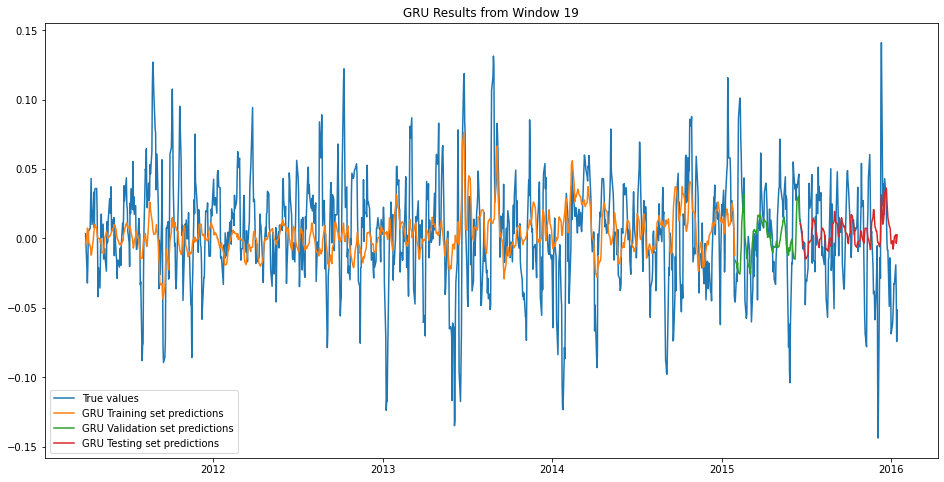

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0013641883590942278
RMSE = 0.0369349205914163
MAE = 0.027455347346603074
R-Squared = 0.029224691161801264

Results on Validation set: 
MSE = 0.0016185885445168502
RMSE = 0.04023168582742774
MAE = 0.0295946742682721
R-Squared = -0.019121970430073354

Results on Testing set: 
MSE = 0.0015760213649585605
RMSE = 0.03969913556941209
MAE = 0.032897617675129706
R-Squared = -0.038266065753086



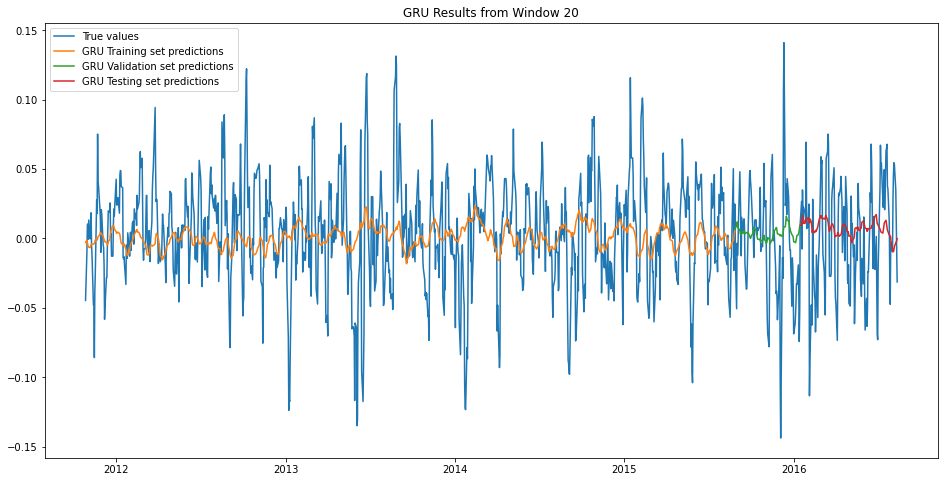

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0015054053299327198
RMSE = 0.038799553218210124
MAE = 0.02937365553562699
R-Squared = 0.03363683245850413

Results on Validation set: 
MSE = 0.0012717774368767253
RMSE = 0.035661988683705306
MAE = 0.029606084825756437
R-Squared = 0.05607784953135109

Results on Testing set: 
MSE = 0.0017967015635455218
RMSE = 0.042387516600356785
MAE = 0.0341103060927187
R-Squared = -0.31870429768267594



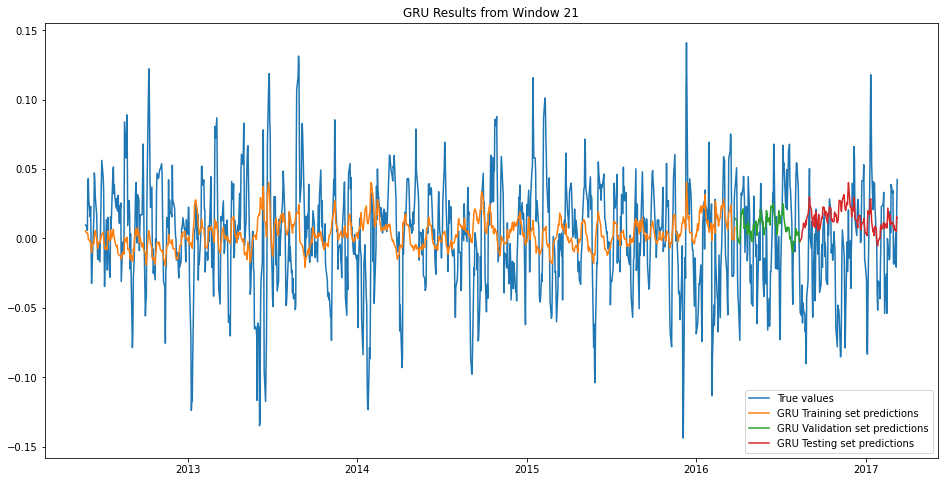

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.001225672803428771
RMSE = 0.03500961015819472
MAE = 0.026220879501637335
R-Squared = 0.22140678203545128

Results on Validation set: 
MSE = 0.001564898650370009
RMSE = 0.039558799910639465
MAE = 0.030515004771130606
R-Squared = -0.008461326573522054

Results on Testing set: 
MSE = 0.0009541825021276285
RMSE = 0.03088984464395424
MAE = 0.024477335067430484
R-Squared = 0.06444079303839534



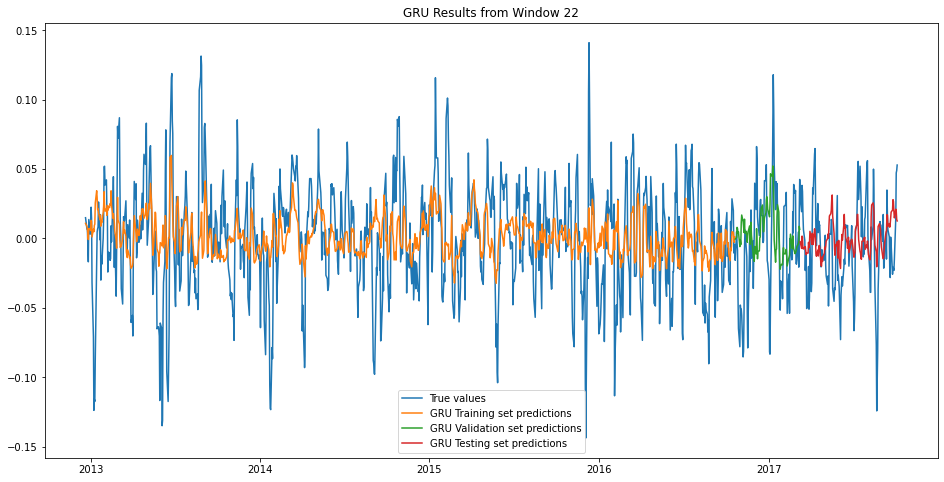

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.001216644224069552
RMSE = 0.03488042752131275
MAE = 0.026582590506024316
R-Squared = 0.14712135504276536

Results on Validation set: 
MSE = 0.0009972573488898676
RMSE = 0.03157938170531316
MAE = 0.024277003791473257
R-Squared = 0.13684244138130364

Results on Testing set: 
MSE = 0.00161291485195932
RMSE = 0.040161111189300026
MAE = 0.031989674403852295
R-Squared = -0.021090133655771615



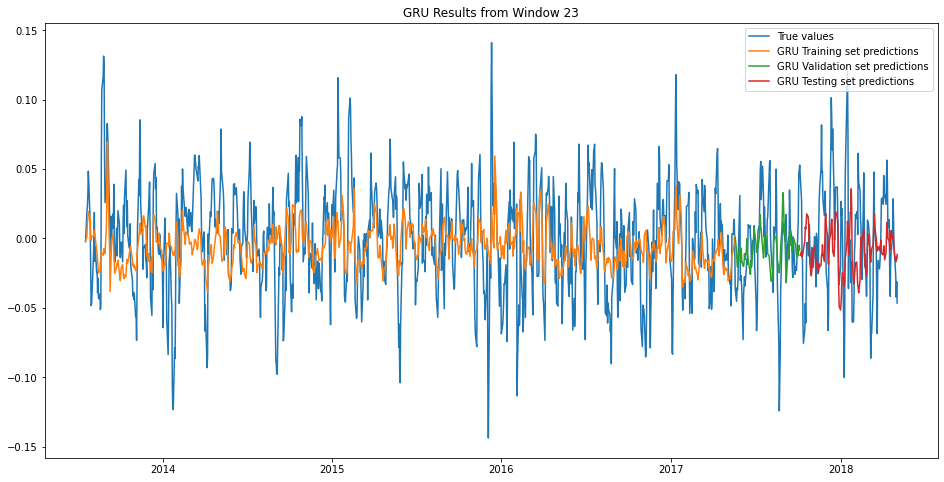

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0012482707023969881
RMSE = 0.03533087463390891
MAE = 0.027014494986152434
R-Squared = 0.08032001090742535

Results on Validation set: 
MSE = 0.0014485027272783007
RMSE = 0.03805920029740904
MAE = 0.029920554275185272
R-Squared = 0.05968416618104455

Results on Testing set: 
MSE = 0.0011543027426569744
RMSE = 0.033975031164915424
MAE = 0.027858603508540518
R-Squared = -0.20641445327341312



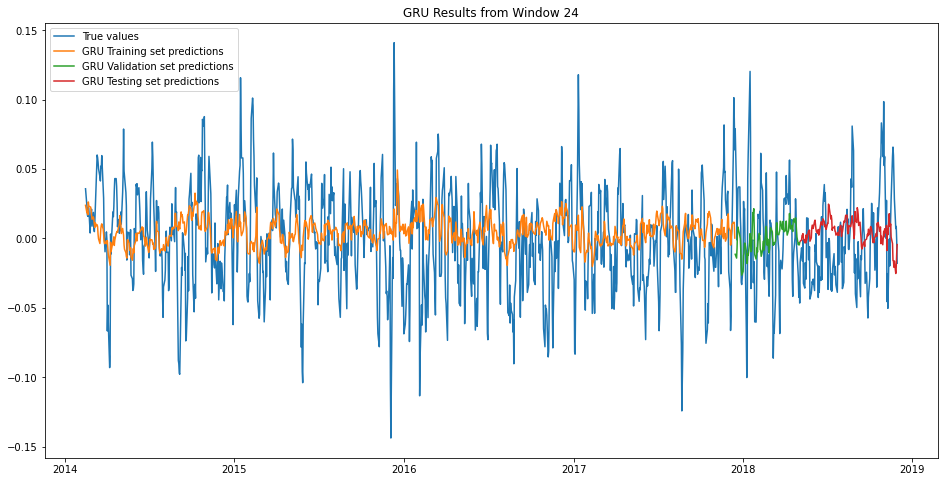

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4977

Results on Training set: 
MSE = 0.000567361743651538
RMSE = 0.023819356491130022
MAE = 0.0178760225758299
R-Squared = 0.584692800702455

Results on Validation set: 
MSE = 0.0011687259023237554
RMSE = 0.0341866333868042
MAE = 0.02517185035529238
R-Squared = -0.05016188731634941

Results on Testing set: 
MSE = 0.002432264652747279
RMSE = 0.049317995222304796
MAE = 0.038461015939027635
R-Squared = -0.493771085207108



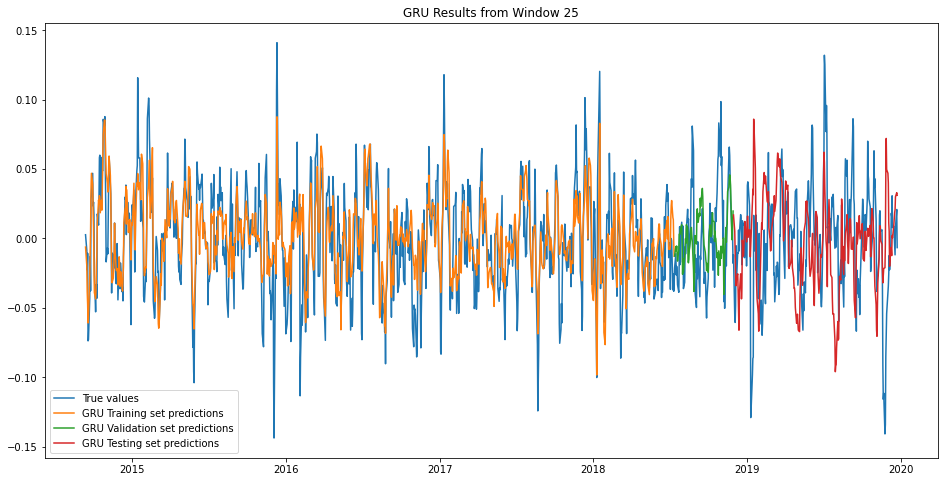

In [10]:
#Declaring model parameters
sequencelength = 141
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.001704474929489755
RMSE = 0.041285287082564355
MAE = 0.030884158440442303
R-Squared = -0.11214503246862195

GRU model results on the Testing set
MSE = 0.0017773630036349653
RMSE = 0.042158783232381904
MAE = 0.032164592976512314
R-Squared = -0.16766382381176315

Naive model results on the Testing set
MSE = 0.003189569736970446
RMSE = 0.05647627587731371
MAE = 0.043193756665869734
R-Squared = -1.0945714342318298

Drift model results on the Testing set
MSE = 0.0039019306140919466
RMSE = 0.06246543535501811
MAE = 0.047165994847192104
R-Squared = -1.5623745760751118



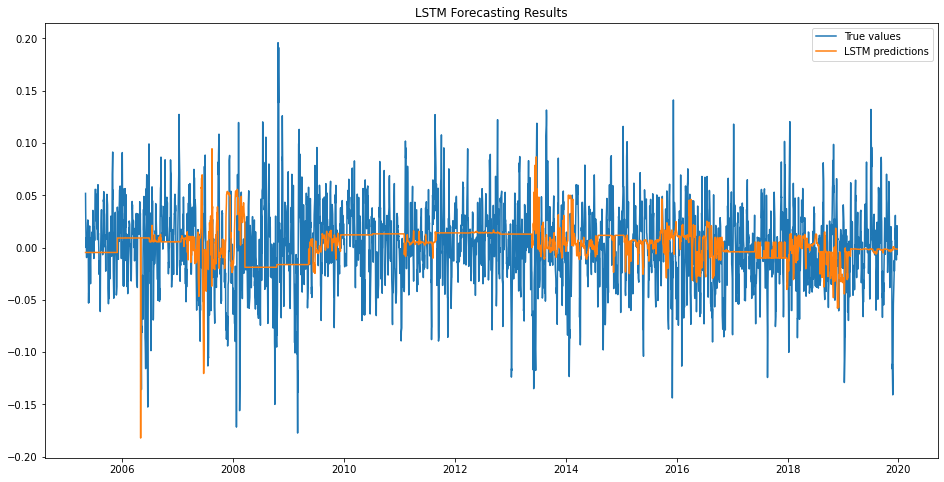

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

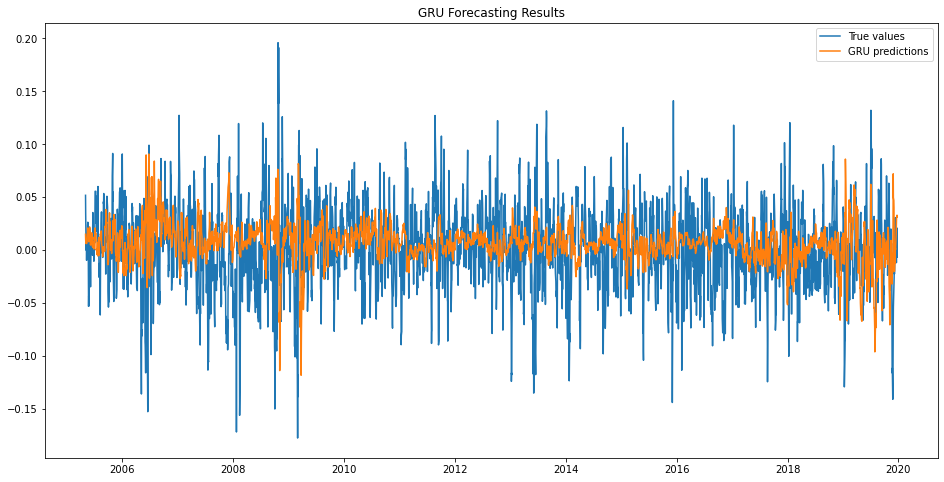

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

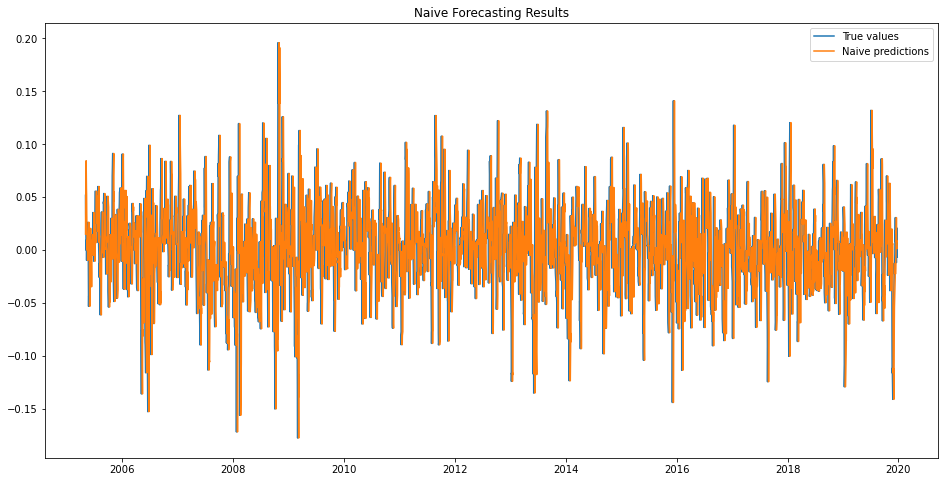

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

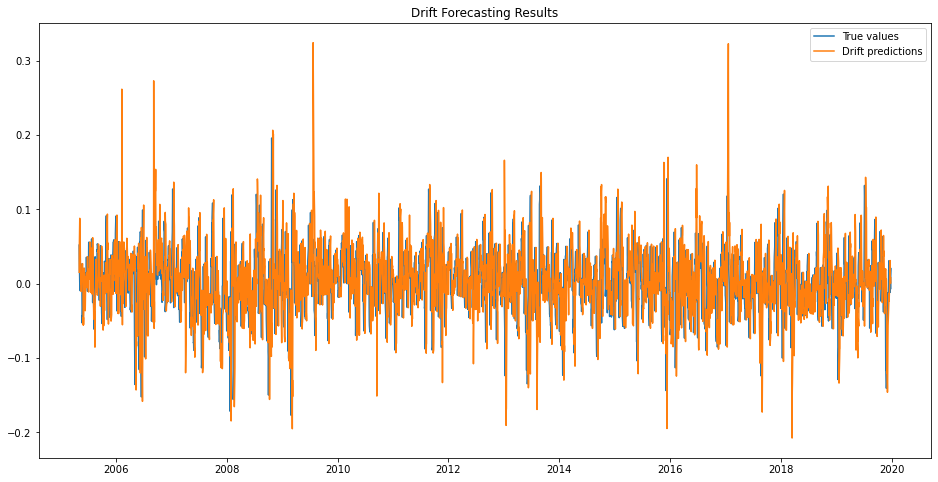

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['WHL LSTM'] = lstm_predictions[-numpreds:]
savePredictions['WHL GRU'] = gru_predictions[-numpreds:]
savePredictions['WHL Naive'] = naive_predictions[-numpreds:]
savePredictions['WHL Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./WHL_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

WHL LSTM   WHL GRU  WHL Naive  WHL Drift
Date                                                
2005-05-05 -0.004682  0.014987   0.015159   0.015215
2005-05-06 -0.004683  0.009350   0.045578   0.047138
2005-05-09 -0.004685  0.006284   0.084417   0.087867
2005-05-10 -0.004685  0.010918   0.066460   0.069004
2005-05-11 -0.004686  0.009547   0.058461   0.060596